In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os

# Load data
directory = "firsttest/test10"

df_training     = pd.read_csv(os.path.join("/home/tvanhout/oxides_ML/models", directory , "training.csv"))
df_train_set    = pd.read_csv(os.path.join("/home/tvanhout/oxides_ML/models", directory , "train_set.csv")) 
df_test_set     = pd.read_csv(os.path.join("/home/tvanhout/oxides_ML/models", directory , "test_set.csv"))
df_val_set      = pd.read_csv(os.path.join("/home/tvanhout/oxides_ML/models", directory , "validation_set.csv"))
df_uq           = pd.read_csv(os.path.join("/home/tvanhout/oxides_ML/models", directory , "uq.csv"))

## Performance metrics

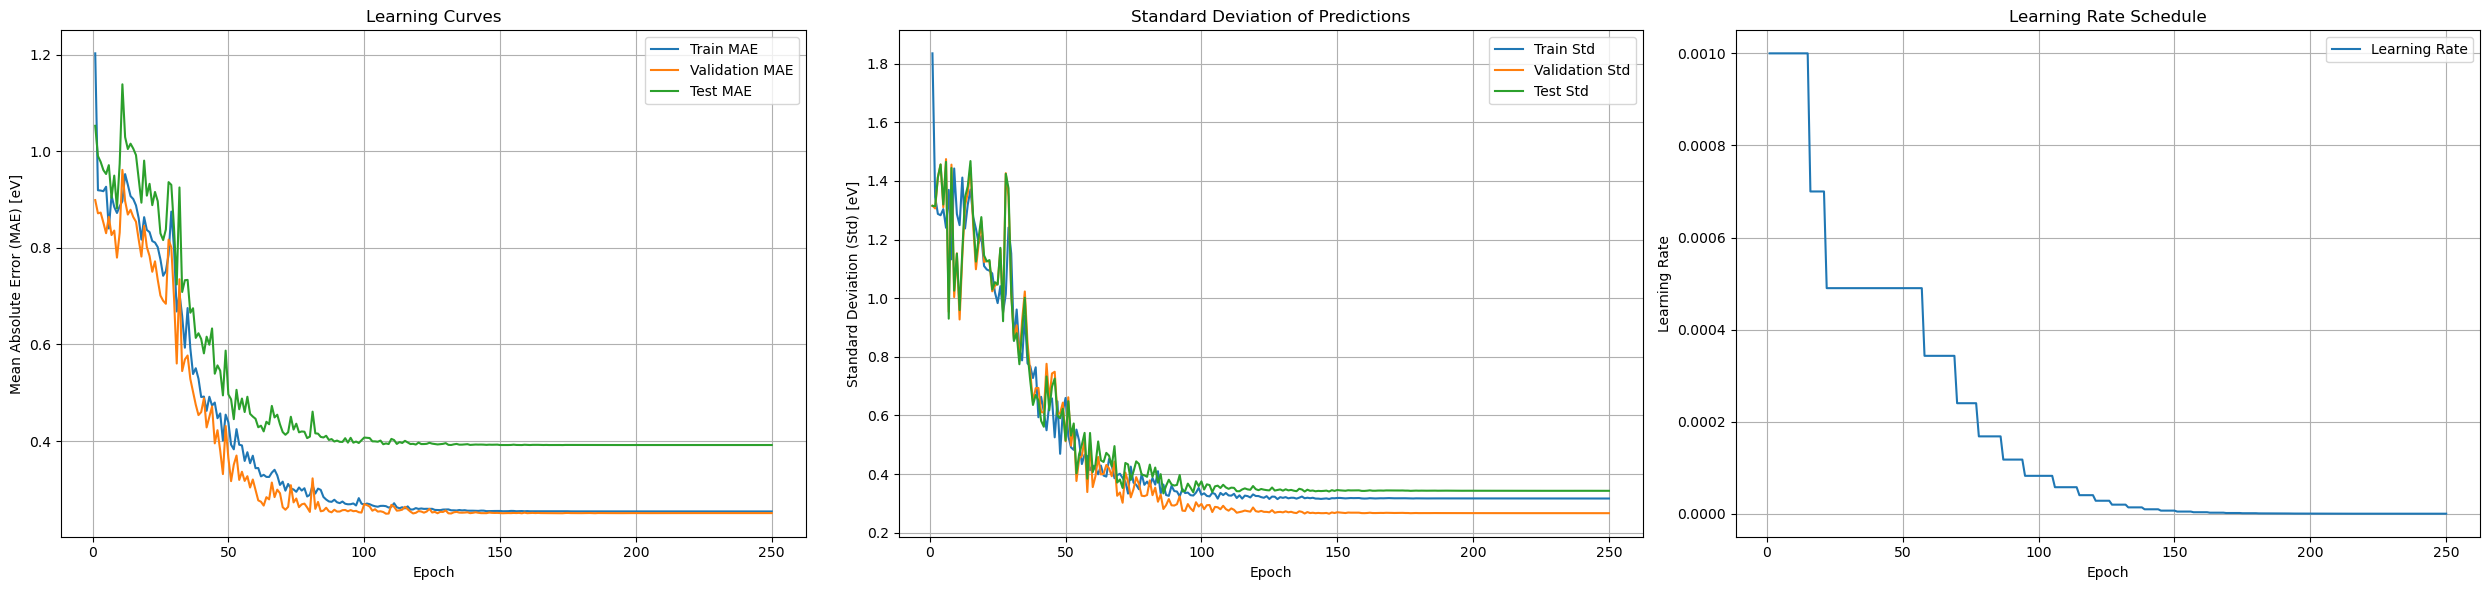

In [2]:
fig, axs = plt.subplots(1, 3, figsize=(25, 6))

# Learning Curves (Train, Val, Test MAE)
axs[0].plot(df_training['Epoch'], df_training['Train_MAE_eV'], label='Train MAE')
axs[0].plot(df_training['Epoch'], df_training['Val_MAE_eV'], label='Validation MAE')
axs[0].plot(df_training['Epoch'], df_training['Test_MAE_eV'], label='Test MAE')

axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Mean Absolute Error (MAE) [eV]')
axs[0].set_title('Learning Curves')
axs[0].legend()
axs[0].grid(True)

# Standard Deviation of Predictions (Train, Val, Test Std)
axs[1].plot(df_training['Epoch'], df_training['Train_std_eV'], label='Train Std')
axs[1].plot(df_training['Epoch'], df_training['Val_std_eV'], label='Validation Std')
axs[1].plot(df_training['Epoch'], df_training['Test_std_eV'], label='Test Std')

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Standard Deviation (Std) [eV]')
axs[1].set_title('Standard Deviation of Predictions')
axs[1].legend()
axs[1].grid(True)

# Learning Rate Schedule
axs[2].plot(df_training['Epoch'], df_training['Learning_Rate'], label='Learning Rate')

axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Learning Rate')
axs[2].set_title('Learning Rate Schedule')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


##  Evaluation of the test set

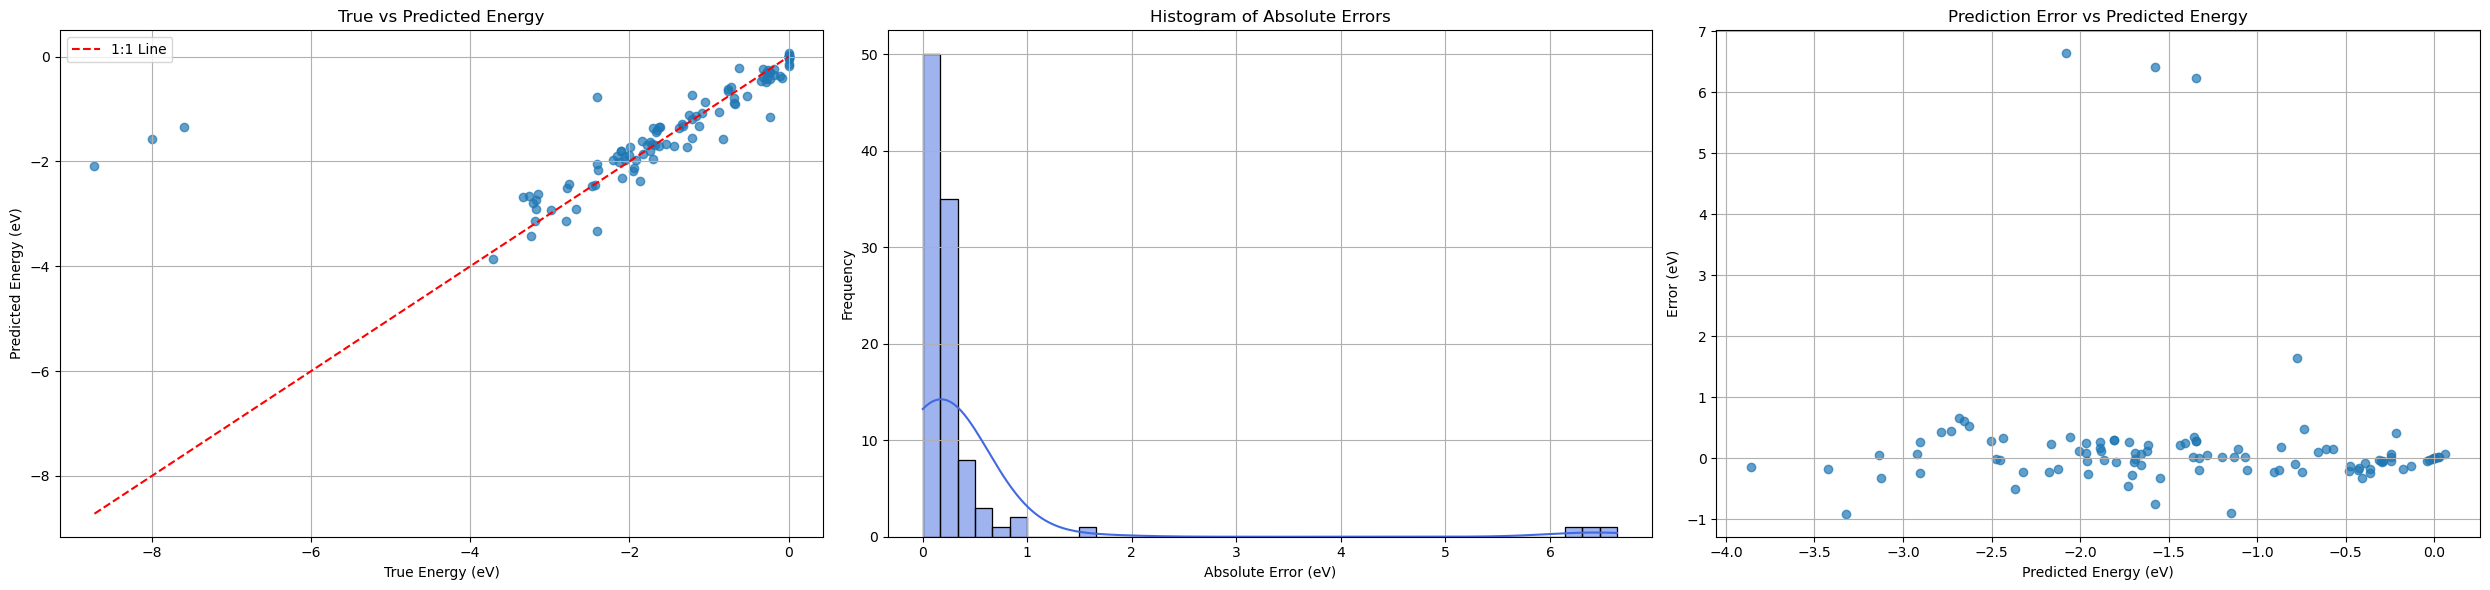

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))  

# True vs. Predicted Energy Plot
axes[0].scatter(df_test_set['True_eV'], df_test_set['Prediction_eV'], alpha=0.7)
axes[0].plot([min(df_test_set['True_eV']), max(df_test_set['True_eV'])], 
             [min(df_test_set['True_eV']), max(df_test_set['True_eV'])], 
             'r--', label='1:1 Line')
axes[0].set_xlabel('True Energy (eV)')
axes[0].set_ylabel('Predicted Energy (eV)')
axes[0].set_title('True vs Predicted Energy')
axes[0].legend()
axes[0].grid(True)

# Histogram of Absolute Errors
sns.histplot(df_test_set['Abs_error_eV'], bins=40, kde=True, color='royalblue', ax=axes[1])
axes[1].set_xlabel('Absolute Error (eV)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Absolute Errors')
axes[1].grid(True)

# Prediction Error vs. Predicted Energy
axes[2].scatter(df_test_set['Prediction_eV'], df_test_set['Error_eV'], alpha=0.7)
axes[2].set_xlabel('Predicted Energy (eV)')
axes[2].set_ylabel('Error (eV)')
axes[2].set_title('Prediction Error vs Predicted Energy')
axes[2].grid(True)

plt.tight_layout()
plt.show()


## Uncertainty quantification

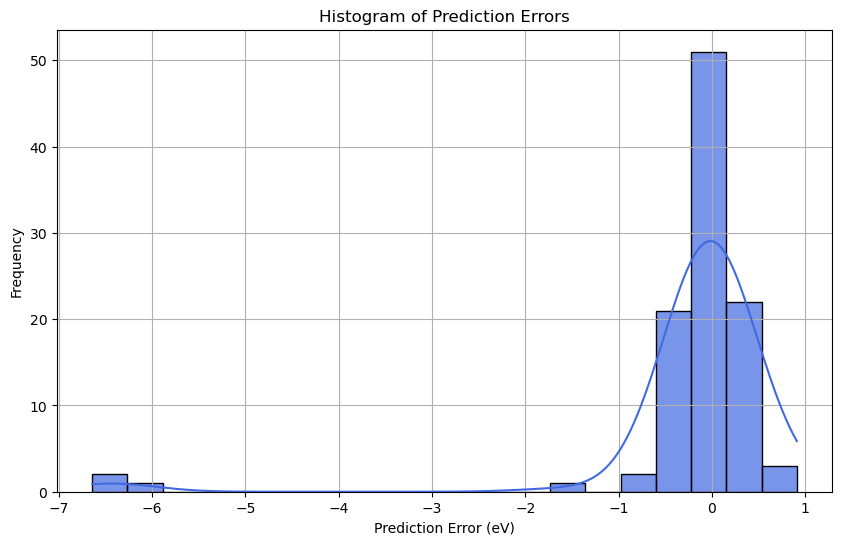

In [4]:
plt.figure(figsize=(10,6))
sns.histplot(df_uq['error'], bins=20, kde = True, color='royalblue', alpha=0.7)

plt.xlabel('Prediction Error (eV)')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.grid(True)
plt.show()


## Evaluation of test set per Molecule Group

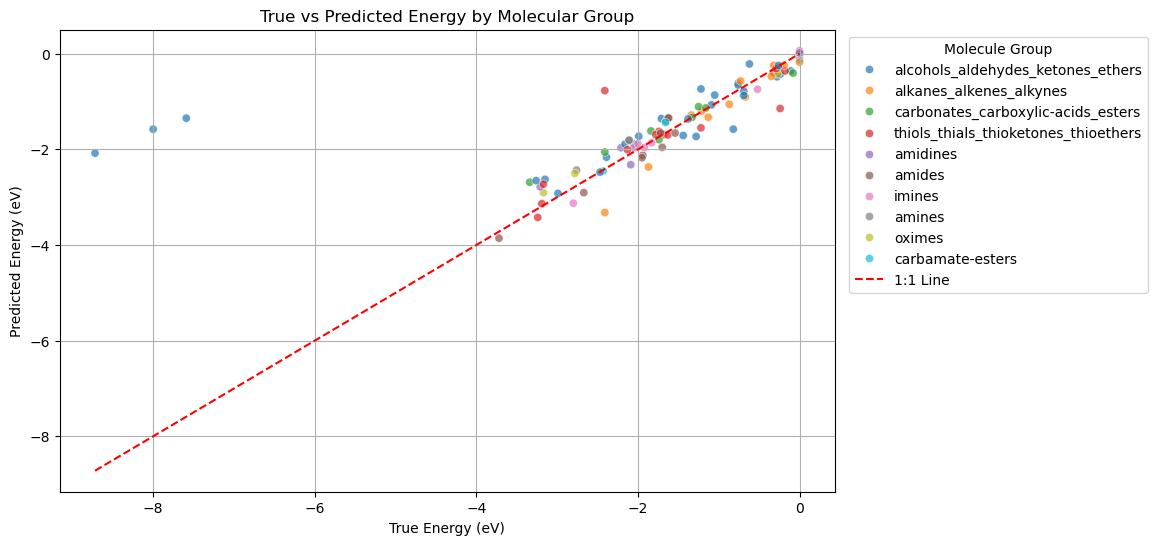

In [50]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_test_set, x='True_eV', y='Prediction_eV', hue='Molecule Group', alpha=0.7)
plt.plot([df_test_set['True_eV'].min(), df_test_set['True_eV'].max()], 
         [df_test_set['True_eV'].min(), df_test_set['True_eV'].max()], 
         'r--', label='1:1 Line')

plt.xlabel('True Energy (eV)')
plt.ylabel('Predicted Energy (eV)')
plt.title('True vs Predicted Energy by Molecular Group')
plt.legend(title="Molecule Group", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True)

plt.show()


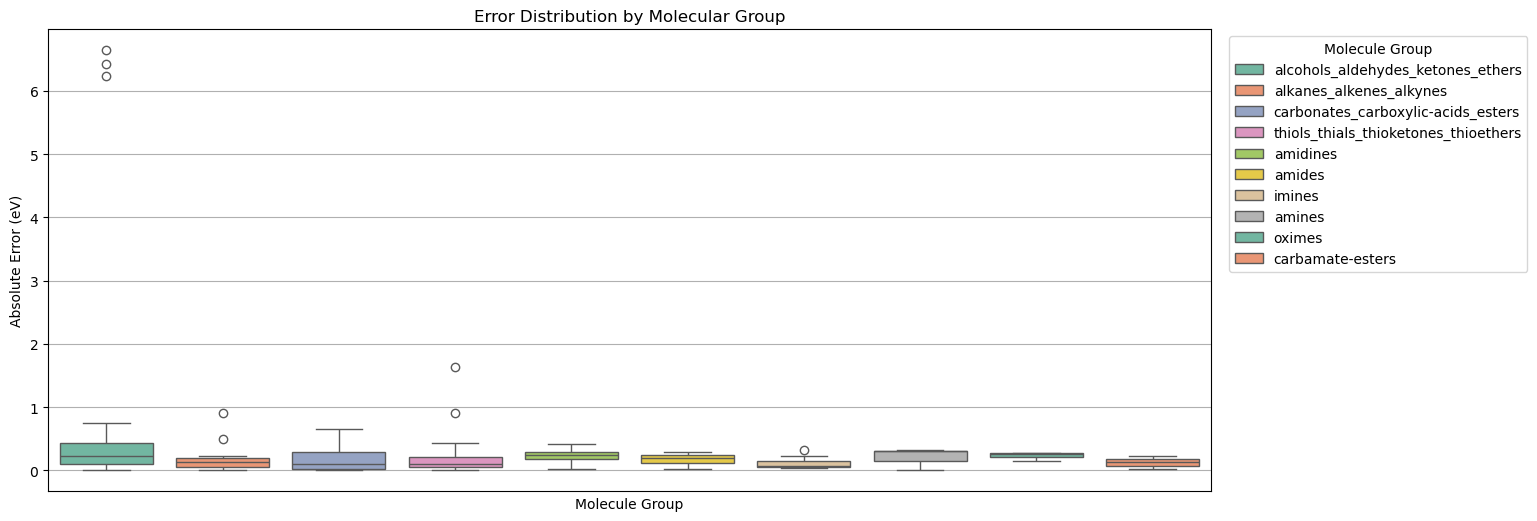

In [51]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_test_set, x='Molecule Group', y='Abs_error_eV', hue='Molecule Group', palette="Set2",legend=True)

plt.xlabel('Molecule Group')
plt.ylabel('Absolute Error (eV)')
plt.title('Error Distribution by Molecular Group')
#plt.xticks(rotation=45)
plt.xticks([])
plt.legend(title="Molecule Group", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True)
plt.show()


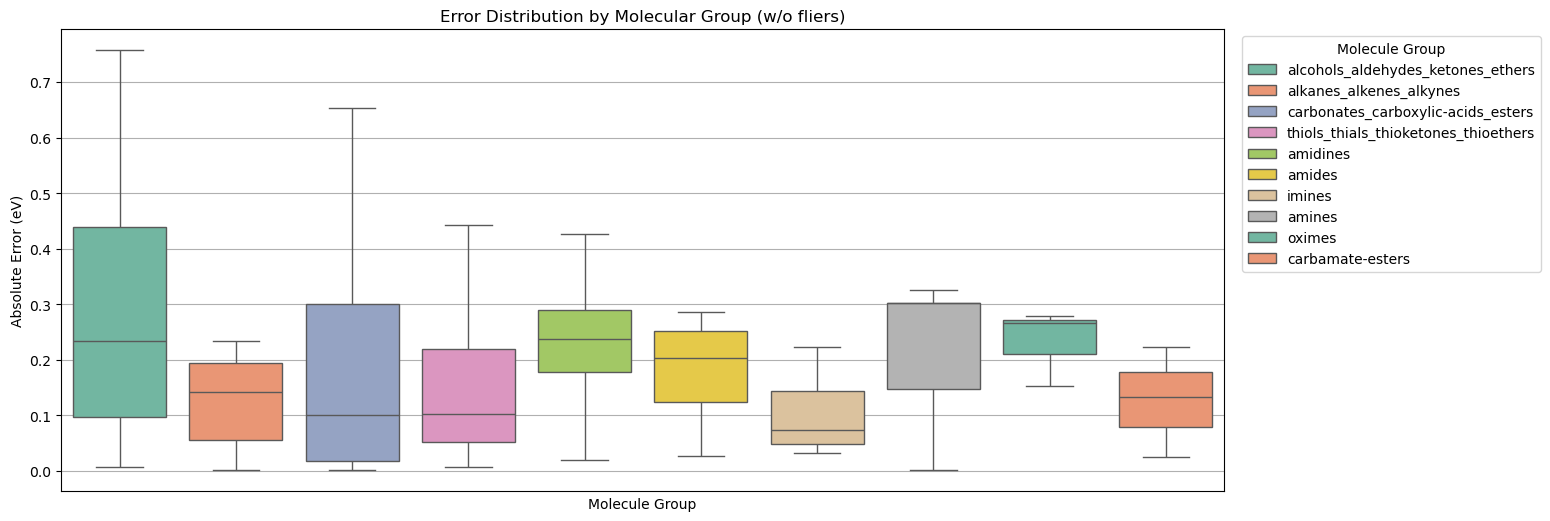

In [67]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_test_set, x='Molecule Group', y='Abs_error_eV', hue='Molecule Group', palette="Set2",legend=True, showfliers=False)

plt.xlabel('Molecule Group')
plt.ylabel('Absolute Error (eV)')
plt.title('Error Distribution by Molecular Group (w/o fliers)')
#plt.xticks(rotation=45)
plt.xticks([])
plt.legend(title="Molecule Group", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True)
plt.show()


## Uncertainty Qualification per Molecule Group

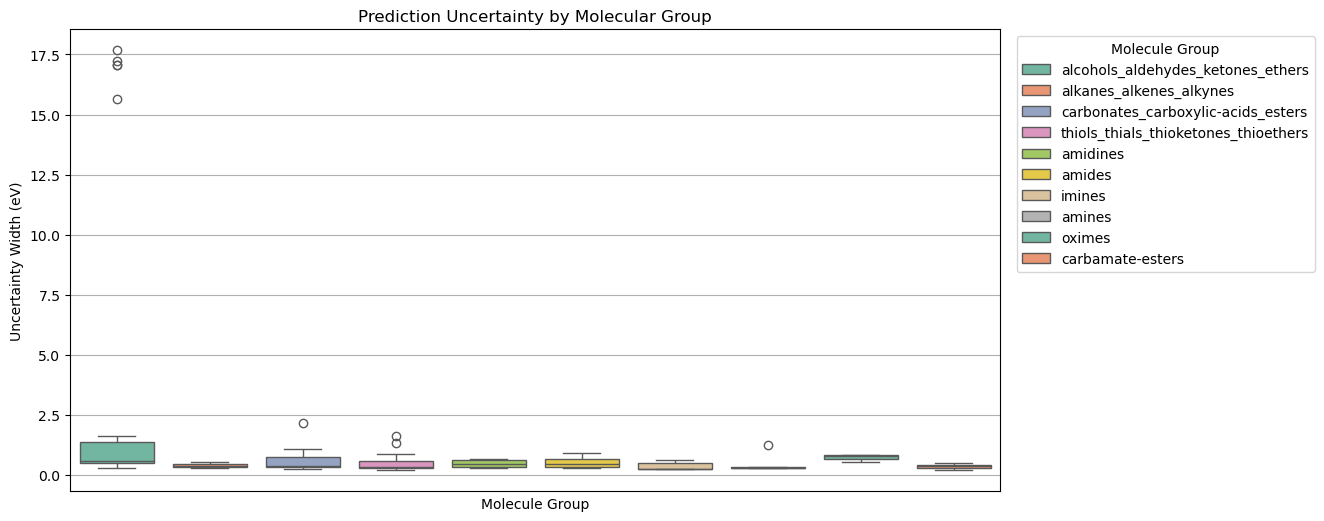

In [53]:
df_uq['uncertainty_width'] = df_uq['y_max'] - df_uq['y_min']

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_uq, x='molecule_group', y='uncertainty_width', hue='molecule_group', palette="Set2", legend=True)

plt.xlabel('Molecule Group')
plt.ylabel('Uncertainty Width (eV)')
plt.title('Prediction Uncertainty by Molecular Group')
#plt.xticks(rotation=45)
plt.xticks([])
plt.legend(title="Molecule Group", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True)
plt.show()


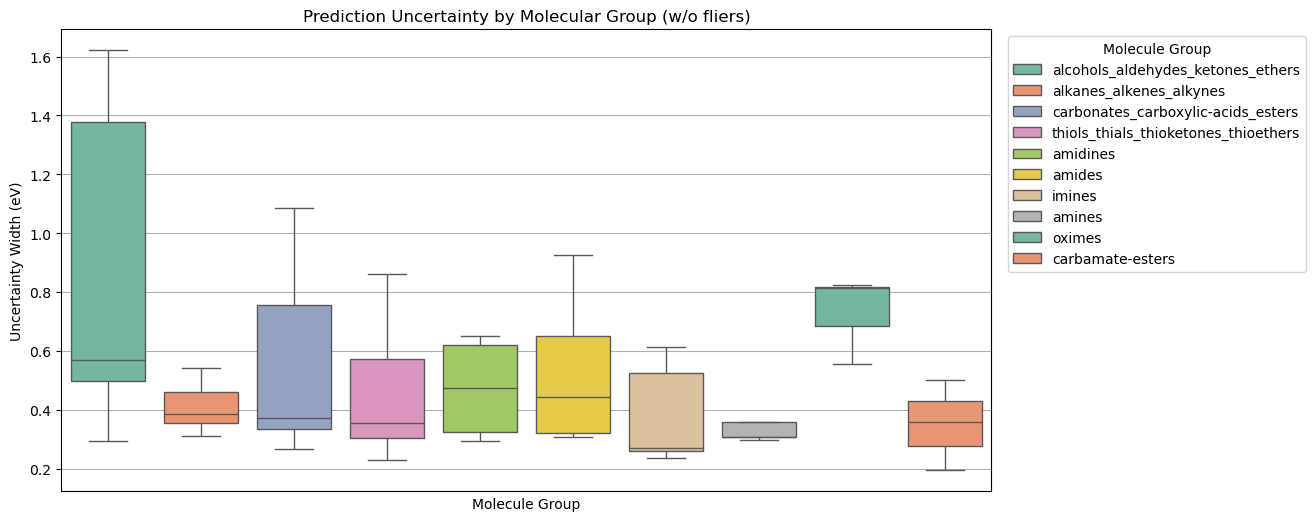

In [69]:
df_uq['uncertainty_width'] = df_uq['y_max'] - df_uq['y_min']

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_uq, x='molecule_group', y='uncertainty_width', hue='molecule_group', palette="Set2", legend=True, showfliers=False)

plt.xlabel('Molecule Group')
plt.ylabel('Uncertainty Width (eV)')
plt.title('Prediction Uncertainty by Molecular Group (w/o fliers)')
#plt.xticks(rotation=45)
plt.xticks([])
plt.legend(title="Molecule Group", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True)
plt.show()